In [1]:
import sys
sys.path.insert(1,'../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib.genhelper import vcf_helper as vhelper
from sklearn.metrics import r2_score
import zarr

In [2]:
from lib.utils import general as g
from lib.data_processing import process_ouput as po

In [3]:
#params
concat_datafame_params ={
    'header':None,
    'sep':' '
}
group_file_key = lambda x: x.split('_')[:-2]
group_key_index = 0
key_cols=[0,1,2,3,4]
key_col_name = 'KEY'
# get group data
# predict
group_list = g.get_group_file('/home/cuong/VBDI/HungProject/GenImputation/data/test/own_hybrid_result/',key = group_file_key)
group_predict_data = {}
for k, paths in group_list[0]:
    key = ''.join(k)
    temp = list(paths)
    group_predict_data[key] = g.concat_dataframe(temp,**concat_datafame_params)
# paper predict
group_list = g.get_group_file('/home/cuong/VBDI/HungProject/GenImputation/data/test/paper_hybrid_result',key = group_file_key)
group_paper_data = {}
for k, paths in group_list[0]:
    key = ''.join(k)
    group_paper_data[key] = g.concat_dataframe(list(paths),**concat_datafame_params)
# groud truth
group_list = g.get_group_file('/home/cuong/VBDI/HungProject/GenImputation/data/test/gtruth_chr22_1_10/',key = group_file_key)
group_gtruth_data = {}
for k, paths in group_list[0]:
    key = ''.join(k)
    group_gtruth_data[key] = g.concat_dataframe(list(paths),**concat_datafame_params)

# get data predict
keys = list(group_predict_data.keys())
predict_data = group_predict_data[keys[group_key_index]]
predict_data_keys = predict_data[key_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# get data predict
keys = list(group_paper_data.keys())
paper_data = group_paper_data[keys[group_key_index]]
predict_paper_keys = paper_data[key_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# get data gt
keys = list(group_gtruth_data.keys())
gtruth_data = group_gtruth_data[keys[group_key_index]]
gtruth_data_keys = gtruth_data[key_cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

assert np.all(predict_data_keys == gtruth_data_keys), 'not same key'

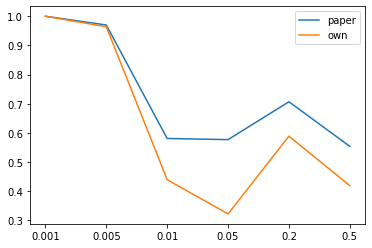

(0.7066233851983763, 0.5980125209595424)

In [7]:
y_paper_pred = paper_data.values[:,5:]
y_me_pred = predict_data.values[:,6:]
mafs = gtruth_data.values[:,5]
y_true = gtruth_data.values[:,6:]
labels, r2_data = po.plot_r2_by_maf(mafs,y_true,{'paper':y_paper_pred,'own':y_me_pred})
r2_score(y_true,y_paper_pred), r2_score(y_true,y_me_pred)

In [5]:
vcfpath = './raw/G1K_chr22.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
raw_callset = zarr.open_group(zarr_path)

--- 221.14914798736572 seconds ---


In [5]:
raw_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [4]:
vcfpath = './interim/G1K_chr22_biallelic.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
biallelic_callset = zarr.open_group(zarr_path)

In [7]:
biallelic_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [5]:
vcfpath = './test/G1K_chr22_biallelic_predict.dose.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
predict_callset = zarr.open_group(zarr_path)

In [9]:
predict_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [6]:
vcfpath = './test/G1K_chr22_biallelic_gtruth.recode.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
gtruth_callset = zarr.open_group(zarr_path)

In [11]:
gtruth_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [7]:
def maf_cal(x):
    return x if x < 0.5 else 1-x
xindex_col = 'PINDEX'
poss_name = 'POS'
alt_name = 'ALT'
af_name = 'AF'
predict_data = pd.DataFrame({
    poss_name : predict_callset.variants.POS[:],
    alt_name : predict_callset.variants.ALT[:,0],
    xindex_col : np.arange(predict_callset.variants.POS.size,dtype=int)
})
yindex_col = 'GINDEX'
gtruth_data = pd.DataFrame({
    poss_name : gtruth_callset.variants.POS[:],
    alt_name : gtruth_callset.variants.ALT[:,0],
    yindex_col : np.arange(gtruth_callset.variants.POS.size,dtype=int),
})
panel_data = pd.DataFrame({
    poss_name : biallelic_callset.variants.POS[:],
    alt_name : biallelic_callset.variants.ALT[:,0],
    af_name : biallelic_callset.variants.AF[:,0]
})
panel_data['AF'] = panel_data['AF'].apply(maf_cal)
panel_data.rename(columns={'AF': 'MAF'},inplace=True)

In [8]:
# Lấy ra dữ liệu và cho biết dữ liệu đó tồn tại ở cùng hay 1 bên của bảng
concat_data = gtruth_data.merge(panel_data, on=['POS','ALT'], how='inner', indicator=True)
concat_data.drop(columns=['_merge'],inplace=True)
concat_data = concat_data.merge(predict_data,on=['POS','ALT'], how='inner', indicator=True)
del gtruth_data
del predict_data
del panel_data

In [12]:
y_pred = predict_callset.calldata.GT[:]
y_pred = y_pred.reshape((y_pred.shape[0],y_pred.shape[1]*2))

y_true = gtruth_callset.calldata.GT[:]
y_true = y_true.reshape((y_true.shape[0],y_true.shape[1]*2))

In [13]:
mafs = concat_data['MAF'].values
indexs = concat_data[xindex_col].values
y_pred = y_pred[indexs]
indexs = concat_data[yindex_col].values
y_true = y_true[indexs]

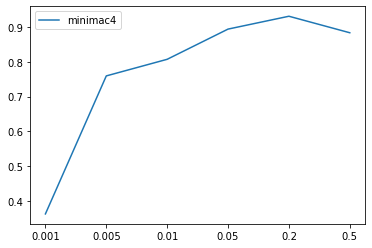

([0.001, 0.005, 0.01, 0.05, 0.2, 0.5],
 {'minimac4': array([0.36224002, 0.75954553, 0.80736203, 0.89431404, 0.93132586,
         0.88379647])})

In [14]:
po.plot_r2_by_maf(mafs,y_true,{'minimac4':y_pred})